# Data Science Project - Machine Learning Part

In [89]:
import numpy as np
import scipy.stats as sc
import pandas as pd

import seaborn as sns
import matplotlib as mpl

import matplotlib.pyplot as plt
from IPython.display import display

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from statsmodels.stats import outliers_influence as oi

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn import metrics 


#######################################################

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 250)
sns.set()

In [38]:
def plot_hist2(df,df2,df_col):
    df = df.dropna()  
    df2 = df2.dropna() 
    for d in df_col:
        print("Empirical Distribution of Variable "+d)
        fig, axes = plt.subplots(1,2,figsize=(15,9))
        sns.distplot(df[d],ax=axes[0])
        sns.distplot(df2[d],ax=axes[1])
        axes[0].set_ylabel("Probability")
        axes[1].set_ylabel("Probability")
        plt.suptitle("Empirical Probability Distribution of Numerical Variable "+d)
        plt.show()
        
def get_num_cols(df):
    idx = df.select_dtypes(exclude='object').columns.values
    dF = df[idx].dropna() #remove NaNs or else it cant plot
    return dF.columns

def calculate_metrics(y_test,y_hat):
    c = confusion_matrix(y_test, y_hat)
    print("Confusion matrix is:")
    print(c)
    print("We have",c[0][0]+c[1][1],"correct observations and",c[0][1]+c[1][0], "misclassifications.")
    print(classification_report(y_test, y_hat))
    
def plot_ROC(y_test,X_test,classifier):
    roc = roc_auc_score(y_test, classifier.predict(X_test))
    fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, label='Classifier area ='+str(np.round(roc,2)))
    plt.plot([0, 1], [0, 1],'--')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend()

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.show()

# Basic info about the dataset

In [39]:
# Data info
dsdata = pd.read_excel('Data/small_dataset.xlsx')

ds = dsdata.copy()
Y = dsdata['y']

display(ds.head(n=5))
ds.info()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
y                 4119 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 675.9+ KB


In [51]:
# Data preparation as all numerical variables
dsn = ds.copy()

numvar = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
nonnumvar = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']
for c,var in enumerate(nonnumvar):
    dsn[var] = dsn[var].astype("category").cat.codes
    
dsn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null int8
marital           4119 non-null int8
education         4119 non-null int8
default           4119 non-null int8
housing           4119 non-null int8
loan              4119 non-null int8
contact           4119 non-null int8
month             4119 non-null int8
day_of_week       4119 non-null int8
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null int8
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
y                 4119 non-null int8
dtypes: float64(5), int64(5), int8(11)
memory usage: 366.1 KB


In [41]:
dsn.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,1,1,2,0,2,0,0,6,0,...,2,999,0,1,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,7,2,3,0,0,0,1,6,0,...,4,999,0,1,1.1,93.994,-36.4,4.855,5191.0,0
2,25,7,1,3,0,2,0,1,4,4,...,1,999,0,1,1.4,94.465,-41.8,4.962,5228.1,0
3,38,7,1,2,0,1,1,1,4,0,...,3,999,0,1,1.4,94.465,-41.8,4.959,5228.1,0
4,47,0,1,6,0,2,0,0,7,1,...,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8,0


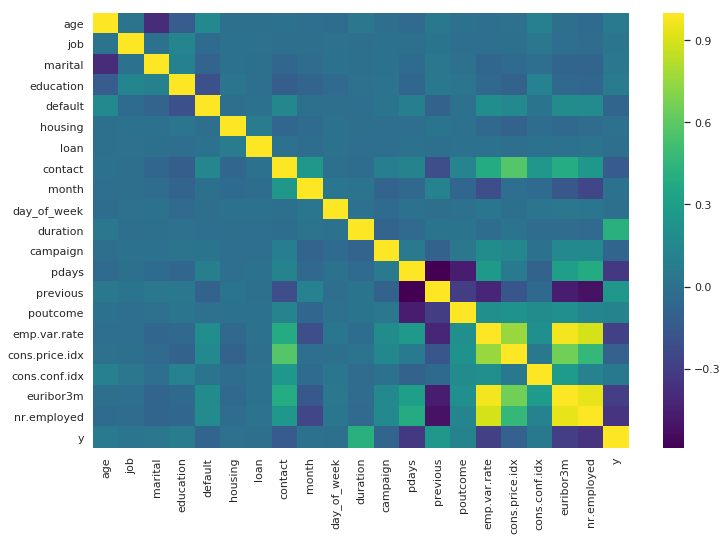

In [50]:
# Check the correlation
plt.figure(figsize=(12,8))
corr = dsn.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,  cmap='viridis')
plt.show()

Notice strong correlation between duration and output, as indeed no call implies no term loan subscription. 
The 'contact' variable (type between 'cellular' and  'telephone' seems to be highly correlated with the social and economic variables.  Also these variables   seem  to be very highly  correlated amongst  each other.

In [45]:
dsn2 = dsn.drop(columns=['duration','y']) #remove output and duration, which should not be known a priori
dsn2.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,1,1,2,0,2,0,0,6,0,2,999,0,1,-1.8,92.893,-46.2,1.313,5099.1
1,39,7,2,3,0,0,0,1,6,0,4,999,0,1,1.1,93.994,-36.4,4.855,5191.0
2,25,7,1,3,0,2,0,1,4,4,1,999,0,1,1.4,94.465,-41.8,4.962,5228.1
3,38,7,1,2,0,1,1,1,4,0,3,999,0,1,1.4,94.465,-41.8,4.959,5228.1
4,47,0,1,6,0,2,0,0,7,1,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


# Linear Regression 

Distribution of OLS residuals


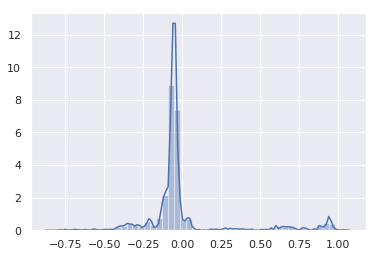

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     55.13
Date:                Fri, 03 May 2019   Prob (F-statistic):          4.60e-186
Time:                        13:38:25   Log-Likelihood:                -581.71
No. Observations:                4119   AIC:                             1203.
Df Residuals:                    4099   BIC:                             1330.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.0631      3.767     -3.468      0.001     -20.449      -5.677
x1             0.0013      0.000      2.682      0.007       0.000       0.002
x2             0.0004      0.001      0.357      0.721      -0.002       0.003
x3             0.0126      0.008      1.602      0.109      -0.003       0.028
x4             0.0029      0.002      1.339      0.181      -0.001       0.007
x5            -0.0061      0.012     -0.525      0.600      -0.029       0.017
x6            -0.0027      0.004     -0.608      0.543      -0.011       0.006
x7            -0.0029      0.006     -0.500      0.617      -0.015       0.009
x8            -0.0993      0.014     -7.132      0.000      -0.127      -0.072
x9            -0.0100      0.003     -3.859      0.000      -0.015      -0.005
x10            0.0026      0.003      0.835      0.404      -0.004       0.009
x11           -0.0029      0.002     -1.670      0.095      -0.006       0.001
x12           -0.0002   5.15e-05     -3.202      0.001      -0.000   -6.39e-05
x13            0.0324      0.017      1.874      0.061      -0.001       0.066
x14            0.0915      0.023      4.001      0.000       0.047       0.136
x15           -0.1215      0.018     -6.730      0.000      -0.157      -0.086
x16            0.1770      0.024      7.495      0.000       0.131       0.223
x17            0.0068      0.002      3.782      0.000       0.003       0.010
x18            0.0499      0.024      2.049      0.041       0.002       0.098
x19           -0.0006      0.000     -1.598      0.110      -0.001       0.000
==============================================================================
Omnibus:                     1737.286   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7121.727
Skew:                           2.095   Prob(JB):                         0.00
Kurtosis:                       7.893   Cond. No.                     4.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

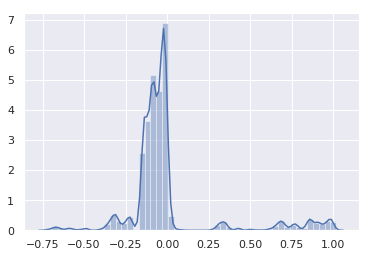

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     98.79
Date:                Fri, 03 May 2019   Prob (F-statistic):          1.36e-167
Time:                        13:38:25   Log-Likelihood:                -646.96
No. Observations:                4119   AIC:                             1314.
Df Residuals:                    4109   BIC:                             1377.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1825      3.176     -1.317      0.188     -10.408       2.043
x1             0.0010      0.000      2.311      0.021       0.000       0.002
x2            -0.0030      0.002     -1.692      0.091      -0.006       0.000
x3            -0.0004   2.92e-05    -12.560      0.000      -0.000      -0.000
x4            -0.0121      0.011     -1.104      0.270      -0.034       0.009
x5            -0.0347      0.016     -2.172      0.030      -0.066      -0.003
x6             0.0807      0.019      4.206      0.000       0.043       0.118
x7             0.0062      0.002      4.031      0.000       0.003       0.009
x8            -0.0140      0.020     -0.693      0.489      -0.054       0.026
x9            -0.0005      0.000     -1.522      0.128      -0.001       0.000
==============================================================================
Omnibus:                     1769.711   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7107.877
Skew:                           2.154   Prob(JB):                         0.00
Kurtosis:                       7.780   Cond. No.                     3.78e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

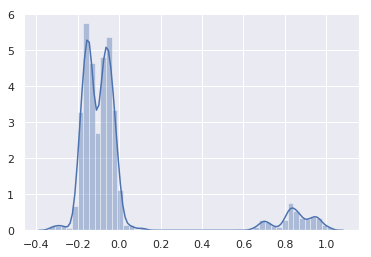

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     20.72
Date:                Fri, 03 May 2019   Prob (F-statistic):           5.15e-38
Time:                        13:38:25   Log-Likelihood:                -949.01
No. Observations:                4119   AIC:                             1920.
Df Residuals:                    4108   BIC:                             1990.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0297      0.023     -1.289      0.197      -0.075       0.015
x1             0.0019      0.001      1.435      0.151      -0.001       0.005
x2             0.0142      0.008      1.791      0.073      -0.001       0.030
x3             0.0050      0.002      2.172      0.030       0.000       0.010
x4            -0.0332      0.012     -2.685      0.007      -0.057      -0.009
x5            -0.0031      0.005     -0.636      0.525      -0.013       0.006
x6            -0.0041      0.006     -0.638      0.524      -0.017       0.009
x7            -0.1044      0.011     -9.858      0.000      -0.125      -0.084
x8             0.0081      0.002      3.740      0.000       0.004       0.012
x9            -0.0020      0.003     -0.582      0.561      -0.009       0.005
x10            0.1235      0.013      9.541      0.000       0.098       0.149
==============================================================================
Omnibus:                     1850.848   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6626.431
Skew:                           2.361   Prob(JB):                         0.00
Kurtosis:                       7.039   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Variance Inflation Factors:
749078.6563993145 const
1.2586054397059838 age
1.0237175515444414 job
1.207428044267209 marital
1.119838269493056 education
1.1099873391194657 default
1.0184331411081826 housing
1.008023239228112 loan
2.3468975123100124 contact
1.8765519615732822 month
1.0144762979088944 day_of_week
1.045741544016227 campaign
5.153238772921849 pdays
4.642419439423065 previous
3.839071033460218 poutcome
42.04314009344721 emp.var.rate
9.877360934620233 cons.price.idx
3.6084373643523033 cons.conf.idx
93.93762644987135 euribor3m
43.308468593441184 nr.employed


In [57]:
X = dsn2.copy().dropna()
Y = pd.DataFrame(dsn.y)

X_numeric = pd.DataFrame(dsn2.dropna(), columns=numvar)
X_cat = pd.DataFrame(dsn2.dropna(), columns= nonnumvar[:-1])

X = sm.add_constant(X)
X_numeric = sm.add_constant(X_numeric)
X_cat = sm.add_constant(X_cat)


model = sm.OLS(Y.values,X.values).fit()
model_n = sm.OLS(Y.values,X_numeric.values).fit()
model_c = sm.OLS(Y.values,X_cat.values).fit()

print("Distribution of OLS residuals")
sns.distplot(model.resid)
plt.show()
display(model.summary())

sns.distplot(model_n.resid)
plt.show()
display(model_n.summary())

sns.distplot(model_c.resid)
plt.show()
display(model_c.summary())

#sm.stats.diagnostic.het_breuschpagan(model.resid)

#print(sm.stats.diagnostic.breaks_cusumolsresid(model.resid, ddof=19))
#print(sm.stats.diagnostic.breaks_cusumolsresid(model_n.resid, ddof=3))
#print(sm.stats.diagnostic.breaks_cusumolsresid(model_c.resid, ddof=16))

#check multicollinearity -> assumption violation
def print_VIF(X):
    colnames = list(X.columns)
    for i in range(X.shape[1]):
        print(oi.variance_inflation_factor(X.values, i), colnames[i])
        
print("Variance Inflation Factors:")        
print_VIF(X)

VIF on emp.var.rate, euribor3m, nr.employed is large, as we saw previosly they are highly correlated. Test regression between economic variables.

Euribor3m is the risk free rate for european banks, so  taking on a  term deposit is only advantageous for the person if the CD offers a higher interest rate than Rf.

In [58]:
X_numeric.head(5)

,const,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.0,30,2,999,0,-1.8,92.893,-46.2,1.313,5099.1
1,1.0,39,4,999,0,1.1,93.994,-36.4,4.855,5191.0
2,1.0,25,1,999,0,1.4,94.465,-41.8,4.962,5228.1
3,1.0,38,3,999,0,1.4,94.465,-41.8,4.959,5228.1
4,1.0,47,1,999,0,-0.1,93.200,-42.0,4.191,5195.8


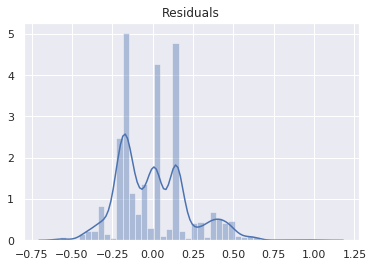

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 6.311e+04
Date:                Fri, 03 May 2019   Prob (F-statistic):               0.00
Time:                        13:46:32   Log-Likelihood:                 401.40
No. Observations:                4119   AIC:                            -792.8
Df Residuals:                    4114   BIC:                            -761.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -91.6439      1.983    -46.223      0.000     -95.531     -87.757
x1             0.4146      0.010     39.506      0.000       0.394       0.435
x2             0.3413      0.014     24.691      0.000       0.314       0.368
x3             0.0531      0.001     63.772      0.000       0.052       0.055
x4             0.0127      0.000     78.506      0.000       0.012       0.013
==============================================================================
Omnibus:                      263.820   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.146
Skew:                           0.650   Prob(JB):                     2.24e-69
Kurtosis:                       3.387   Cond. No.                     2.99e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
numeric = sm.OLS(X_numeric.euribor3m.values,X_numeric.drop(columns=['previous','pdays','age','campaign','euribor3m']).values).fit()
sns.distplot(numeric.resid)
plt.title("Residuals")
plt.show()
display(numeric.summary())

Strong regression results, remove it, check VIF again.

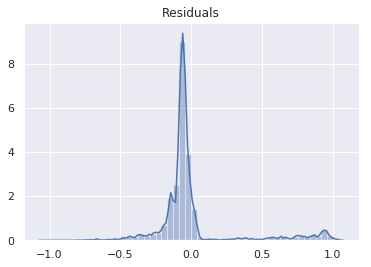

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     29.82
Date:                Fri, 03 May 2019   Prob (F-statistic):           4.08e-86
Time:                        13:48:35   Log-Likelihood:                -613.48
No. Observations:                4119   AIC:                             1261.
Df Residuals:                    4102   BIC:                             1368.
Df Model:                          16                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1093      1.200      1.757      0.079      -0.243       4.462
x1             0.0013      0.001      2.354      0.019       0.000       0.002
x2             0.0006      0.001      0.487      0.626      -0.002       0.003
x3             0.0127      0.008      1.615      0.106      -0.003       0.028
x4             0.0028      0.002      1.312      0.189      -0.001       0.007
x5            -0.0090      0.010     -0.908      0.364      -0.028       0.010
x6            -0.0037      0.004     -0.829      0.407      -0.013       0.005
x7            -0.0026      0.006     -0.443      0.657      -0.014       0.009
x8            -0.0687      0.014     -4.879      0.000      -0.096      -0.041
x9            -0.0069      0.002     -2.823      0.005      -0.012      -0.002
x10            0.0018      0.003      0.565      0.572      -0.004       0.008
x11           -0.0034      0.001     -3.204      0.001      -0.005      -0.001
x12            0.0777      0.016      4.906      0.000       0.047       0.109
x13            0.1534      0.019      8.128      0.000       0.116       0.190
x14            0.0582      0.016      3.682      0.000       0.027       0.089
x15            0.0053      0.001      3.816      0.000       0.003       0.008
x16           -0.0014      0.000    -11.465      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     1769.288   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7170.509
Skew:                           2.149   Prob(JB):                         0.00
Kurtosis:                       7.829   Cond. No.                     1.08e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Variance Inflation Factors:
43543.052442446744 const
1.2560419624950632 age
1.022921411344123 job
1.2073998896587543 marital
1.1177705074830648 education
1.107497579851493 default
1.0172480469050837 housing
1.0073122516346926 loan
1.9667925282560457 contact
1.2641925235232867 month
1.0128046018457288 day_of_week
1.040875374300601 campaign
1.5984977903259436 previous
1.2171183751276404 poutcome
2.065091759699086 cons.price.idx
1.2073464510940786 cons.conf.idx
1.9631307929624677 nr.employed


In [65]:
X2 = X.drop(columns=['euribor3m','emp.var.rate','pdays'])
model2 = sm.OLS(Y.values,X2.values).fit(cov_type='HC0')
sns.distplot(model2.resid)
plt.title("Residuals")
plt.show()
display(model2.summary())
print("Variance Inflation Factors:")
print_VIF(X2)

All VIFs are low now, so no more multicollinearity. Remove statistically insignificant regressors.

In [66]:
alpha = 0.05
a = model2.pvalues < alpha

In [69]:
X3 = X2[X2.columns[a]]
X3 = sm.add_constant(X3)
print("Not Statistically significant regressors are:")
print(list(X2.columns[~a]))

Not Statistically significant regressors are:
['const', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'day_of_week']


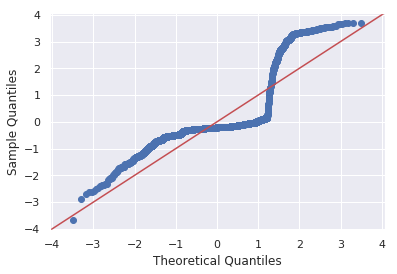

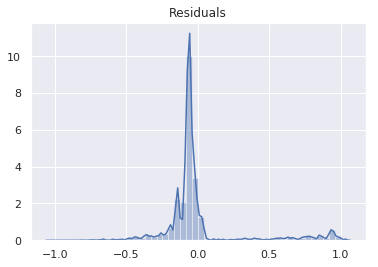

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     52.14
Date:                Fri, 03 May 2019   Prob (F-statistic):           3.92e-90
Time:                        13:50:27   Log-Likelihood:                -617.06
No. Observations:                4119   AIC:                             1254.
Df Residuals:                    4109   BIC:                             1317.
Df Model:                           9                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2132      1.198      1.848      0.065      -0.134       4.560
x1             0.0009      0.001      1.696      0.090      -0.000       0.002
x2            -0.0721      0.014     -5.159      0.000      -0.100      -0.045
x3            -0.0071      0.002     -2.931      0.003      -0.012      -0.002
x4            -0.0033      0.001     -3.100      0.002      -0.005      -0.001
x5             0.0779      0.016      4.934      0.000       0.047       0.109
x6             0.1540      0.019      8.171      0.000       0.117       0.191
x7             0.0590      0.016      3.742      0.000       0.028       0.090
x8             0.0057      0.001      4.153      0.000       0.003       0.008
x9            -0.0015      0.000    -11.641      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     1776.704   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7232.247
Skew:                           2.157   Prob(JB):                         0.00
Kurtosis:                       7.850   Cond. No.                     1.07e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Variance Inflation Factors:
42758.43667973563 const
1.0153793550911234 age
1.9396051841953905 contact
1.2506802283213385 month
1.0374957108920952 campaign
1.595683579189539 previous
1.2112331954316085 poutcome
2.045401964238995 cons.price.idx
1.17345907833012 cons.conf.idx
1.9236030812961207 nr.employed


In [70]:
model3 = sm.OLS(Y.values,X3.values).fit(cov_type='HC0')
sm.qqplot(model3.resid, sc.norm, fit=True, line='45')
plt.show()
sns.distplot(model3.resid)
plt.title('Residuals')
plt.show()
display(model3.summary())
print("Variance Inflation Factors:")
print_VIF(X3)
#sm.stats.diagnostic.breaks_hansen(model3)

In [72]:
L = list(X3.columns)
Sgn = model3.params
for i in range(len(model3.params)):
    print(L[i],':', np.round(Sgn[i],3))

const : 2.213
age : 0.001
contact : -0.072
month : -0.007
campaign : -0.003
previous : 0.078
poutcome : 0.154
cons.price.idx : 0.059
cons.conf.idx : 0.006
nr.employed : -0.001


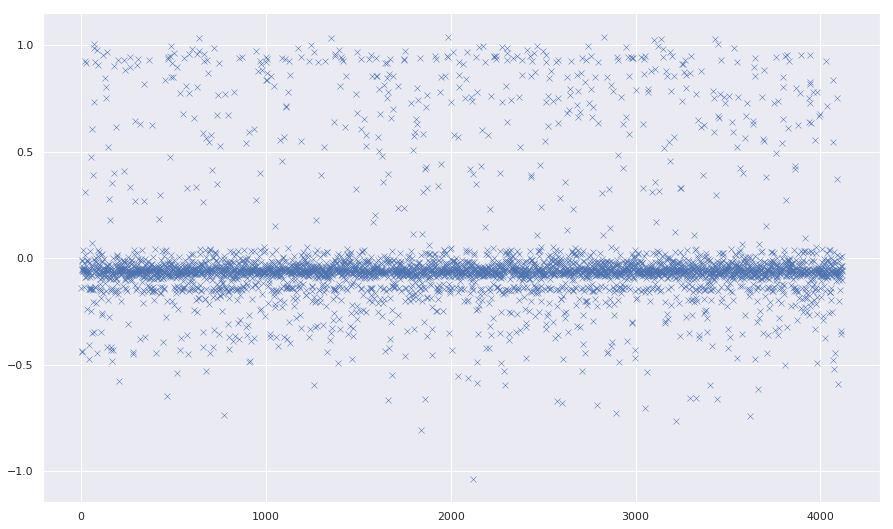

In [73]:
plt.figure(figsize=(15,9))
plt.scatter(np.ones((model3.resid.shape[0],1)).cumsum(),model3.resid, marker='x', linewidth=0.5)

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X3.values, Y.values, test_size=0.25)

reg = LinearRegression()
reg = reg.fit(X_train,Y_train)

y_hat = reg.predict(X_test)

print('Test accuracy:',np.round(reg.score(X_test, Y_test),3), ', MSE Loss is:', mean_squared_error(Y_test,y_hat))


Test accuracy: 0.198 , MSE Loss is: 0.07774769670199845


# Linear Classification: Logistic Regression

,const,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,nr.employed
count,4119.0,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,1.0,40.113620,3.824958,1.176985,3.780286,0.195436,1.081573,0.348386,0.356154,4.294975,2.009711,2.537266,0.190337,0.924253,93.579704,-40.499102,5166.481695
std,0.0,10.313362,3.606319,0.606341,2.149588,0.397196,0.983915,0.741647,0.478920,2.305188,1.389233,2.568159,0.541788,0.372816,0.579349,4.594578,73.667904
min,1.0,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,92.201000,-50.800000,4963.600000
25%,1.0,32.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,93.075000,-42.700000,5099.100000
50%,1.0,38.000000,3.000000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,2.000000,0.000000,1.000000,93.749000,-41.800000,5191.000000
75%,1.0,47.000000,7.000000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,3.000000,0.000000,1.000000,93.994000,-36.400000,5228.100000
max,1.0,88.000000,11.000000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,35.000000,6.000000,2.000000,94.767000,-26.900000,5228.100000


,y
count,4119.000000
mean,0.109493
std,0.312294
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


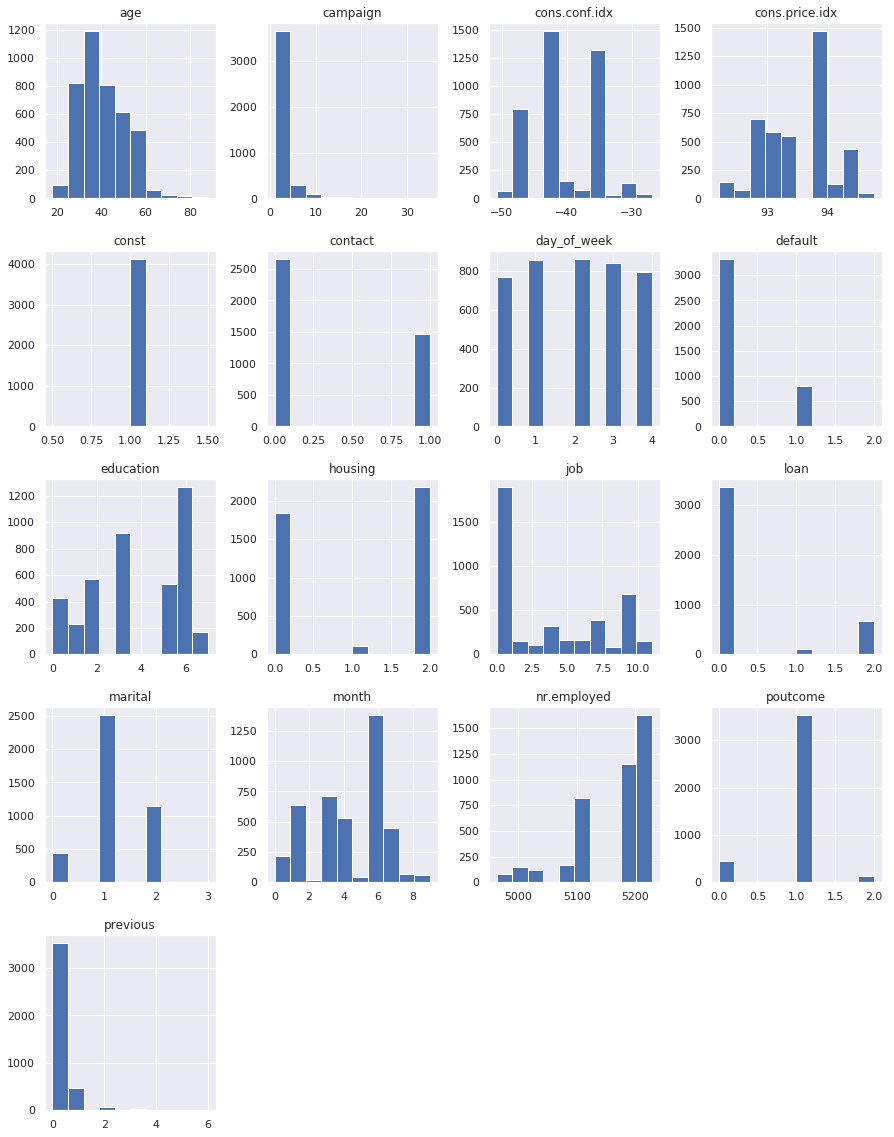

In [78]:
display(X2.describe())
display(Y.describe())
X2.hist(figsize=(15,20))
plt.show()

In [79]:
logit = sm.Logit(Y.values, X2.values).fit()
display(logit.summary())

Optimization terminated successfully.
         Current function value: 0.277322
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4119
Model:                          Logit   Df Residuals:                     4102
Method:                           MLE   Df Model:                           16
Date:                Fri, 03 May 2019   Pseudo R-squ.:                  0.1972
Time:                        13:54:09   Log-Likelihood:                -1142.3
converged:                       True   LL-Null:                       -1422.9
                                        LLR p-value:                3.700e-109
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.7222      9.738      3.874      0.000      18.637      56.808
x1             0.0139      0.005      2.551      0.011       0.003       0.025
x2             0.0079      0.015      0.513      0.608      -0.022       0.038
x3             0.1701      0.103      1.653      0.098      -0.032       0.372
x4             0.0392      0.028      1.404      0.160      -0.016       0.094
x5            -0.0993      0.173     -0.574      0.566      -0.438       0.240
x6            -0.0534      0.057     -0.934      0.350      -0.165       0.059
x7            -0.0287      0.077     -0.372      0.710      -0.180       0.122
x8            -0.6077      0.168     -3.611      0.000      -0.937      -0.278
x9            -0.0685      0.023     -2.976      0.003      -0.114      -0.023
x10            0.0237      0.041      0.578      0.563      -0.057       0.104
x11           -0.0780      0.034     -2.302      0.021      -0.144      -0.012
x12            0.2730      0.091      2.992      0.003       0.094       0.452
x13            0.8488      0.119      7.131      0.000       0.616       1.082
x14            0.1707      0.104      1.648      0.099      -0.032       0.374
x15            0.0284      0.011      2.655      0.008       0.007       0.049
x16           -0.0109      0.001    -13.516      0.000      -0.012      -0.009
==============================================================================
"""

In [80]:
b = logit.pvalues < alpha
X4 = X2[X2.columns[b]]
print("Not Statistically significant regressors are:")
print(list(X2.columns[~b]))
print_VIF(X4)

Not Statistically significant regressors are:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'day_of_week', 'cons.price.idx']
8072.874244500625 const
1.0151260650495144 age
1.3284074819743443 contact
1.2402833143173353 month
1.0341747011995708 campaign
1.4936803458069854 previous
1.1453102375797155 poutcome
1.120277731537019 cons.conf.idx
1.5734398204652942 nr.employed


In [83]:
logit2 = sm.Logit(Y.values, X4.values).fit()


#odds ratio, how a 1 unit increase in every variable affects churn chances
print(np.exp(logit2.params))
display(logit2.summary())

Optimization terminated successfully.
         Current function value: 0.278619
         Iterations 7
[4.93321679e+23 1.00817879e+00 5.95753846e-01 9.30370171e-01
 9.29237331e-01 1.36018860e+00 2.37856134e+00 1.02765504e+00
 9.89131201e-01]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4119
Model:                          Logit   Df Residuals:                     4110
Method:                           MLE   Df Model:                            8
Date:                Fri, 03 May 2019   Pseudo R-squ.:                  0.1935
Time:                        13:54:51   Log-Likelihood:                -1147.6
converged:                       True   LL-Null:                       -1422.9
                                        LLR p-value:                9.757e-114
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.5554      4.036     13.517      0.000      46.645      62.466
x1             0.0081      0.005      1.717      0.086      -0.001       0.017
x2            -0.5179      0.150     -3.443      0.001      -0.813      -0.223
x3            -0.0722      0.023     -3.204      0.001      -0.116      -0.028
x4            -0.0734      0.034     -2.175      0.030      -0.140      -0.007
x5             0.3076      0.088      3.491      0.000       0.135       0.480
x6             0.8665      0.117      7.425      0.000       0.638       1.095
x7             0.0273      0.010      2.776      0.006       0.008       0.047
x8            -0.0109      0.001    -14.037      0.000      -0.012      -0.009
==============================================================================
"""

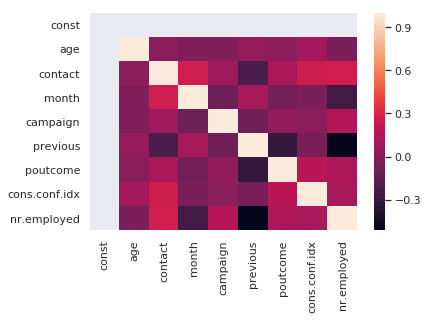

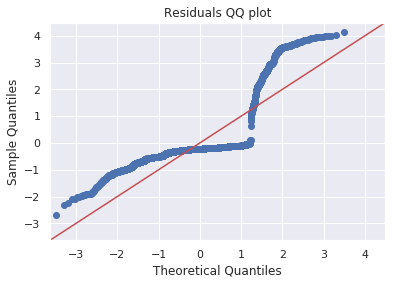

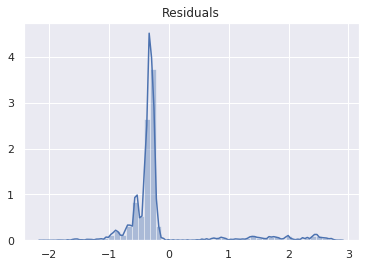

In [84]:
sns.heatmap(X4.corr(), xticklabels=X4.corr().columns,yticklabels=X4.corr().columns)
plt.show()
sm.qqplot(logit2.resid_dev, sc.norm, fit=True, line='45')
plt.title('Residuals QQ plot')
plt.show()
sns.distplot(logit2.resid_dev)
plt.title('Residuals')
plt.show()

In [86]:
L2 = list(X4.columns)
Sgn2 = logit2.params
for i in range(len(logit2.params)):
    print(L2[i],':', np.round(np.exp(Sgn2[i]),3))

const : 4.933216791534352e+23
age : 1.008
contact : 0.596
month : 0.93
campaign : 0.929
previous : 1.36
poutcome : 2.379
cons.conf.idx : 1.028
nr.employed : 0.989


# Prediction with Logitsic Regression and Identified Variables

In [87]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X4.values, Y.values, test_size=0.25)
    lr = LogisticRegression().fit(X_train,y_train)

    y_hat = lr.predict(X_test)
    print('Test accuracy:',np.round(lr.score(X_test, y_test),3), ', Cross Entropy Loss is:', log_loss(y_test,y_hat))


Test accuracy: 0.911 , Cross Entropy Loss is: 3.085024683792316
Test accuracy: 0.897 , Cross Entropy Loss is: 3.554479122573062
Test accuracy: 0.891 , Cross Entropy Loss is: 3.7556774308879404
Test accuracy: 0.899 , Cross Entropy Loss is: 3.4874174188811486
Test accuracy: 0.894 , Cross Entropy Loss is: 3.655083710887794
Test accuracy: 0.896 , Cross Entropy Loss is: 3.588015796730403
Test accuracy: 0.903 , Cross Entropy Loss is: 3.353284695799107
Test accuracy: 0.894 , Cross Entropy Loss is: 3.6550806056550553
Test accuracy: 0.897 , Cross Entropy Loss is: 3.554483004113985
Test accuracy: 0.889 , Cross Entropy Loss is: 3.822746897661699


Confusion matrix is:
[[902  11]
 [103  14]]
We have 916 correct observations and 114 misclassifications.
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       913
           1       0.56      0.12      0.20       117

   micro avg       0.89      0.89      0.89      1030
   macro avg       0.73      0.55      0.57      1030
weighted avg       0.86      0.89      0.86      1030



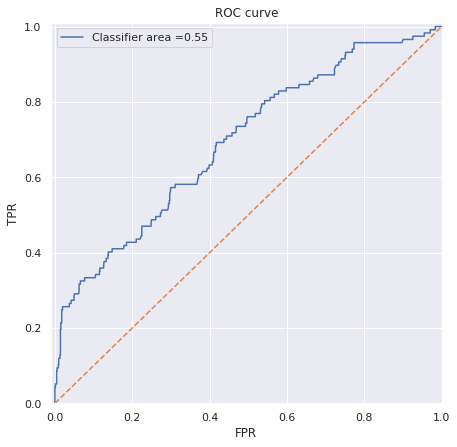

In [88]:
calculate_metrics(y_test,y_hat)
plot_ROC(y_test,X_test,lr)

# Other Models

Split the data into train and test dataset. Would need to find signficant regressors again with statsmodels, but for more complex models this isnt easy, so just use the design matrix without multicollinearity.

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X2.values, Y.values, test_size=0.25)


## Classification - Decision tree

Test accuracy: 0.825 , Cross Entropy Loss is: 6.035981078081916
Confusion matrix is:
[[817 101]
 [ 79  33]]
We have 850 correct observations and 180 misclassifications.
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       918
           1       0.25      0.29      0.27       112

   micro avg       0.83      0.83      0.83      1030
   macro avg       0.58      0.59      0.58      1030
weighted avg       0.84      0.83      0.83      1030



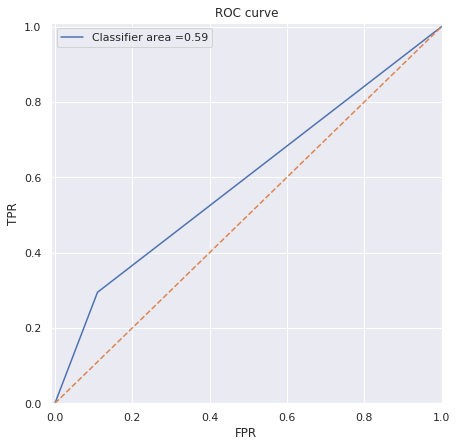

In [91]:
clf_detree = DecisionTreeClassifier()
clf_detree = clf_detree.fit(X_train,Y_train)


y_hat = clf_detree.predict(X_test)

print('Test accuracy:',np.round(clf_detree.score(X_test, Y_test),3), ', Cross Entropy Loss is:', log_loss(Y_test,y_hat))
calculate_metrics(Y_test,y_hat)
plot_ROC(Y_test,X_test,clf_detree)

## Classification - Random Forest

Test accuracy: 0.899 , Cross Entropy Loss is: 3.487421300422072
Confusion matrix is:
[[904  14]
 [ 90  22]]
We have 926 correct observations and 104 misclassifications.
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       918
           1       0.61      0.20      0.30       112

   micro avg       0.90      0.90      0.90      1030
   macro avg       0.76      0.59      0.62      1030
weighted avg       0.88      0.90      0.88      1030



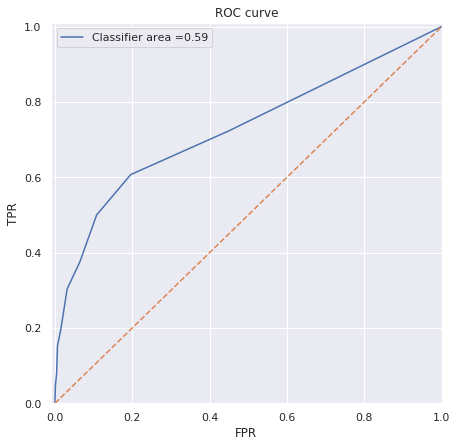

In [92]:
clf_rdfore = RandomForestClassifier()
clf_rdfore = clf_rdfore.fit(X_train,Y_train)

y_hat = clf_rdfore.predict(X_test)


print('Test accuracy:',np.round(clf_rdfore.score(X_test, Y_test),3), ', Cross Entropy Loss is:', log_loss(Y_test,y_hat))
calculate_metrics(Y_test,y_hat)
plot_ROC(Y_test,X_test,clf_rdfore)

## Classification - other

In [27]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for c,var in enumerate(classifiers):
    clf = var
    clf = clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    print(c,var,"Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') Accuracy: 0.7571103526734926
1 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) Accuracy: 0.7815699658703071
2 GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False) Accuracy: 0.7366325369738339
3 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
          